In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import nbformat
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,5)


In [14]:

csv_path = 'Food_Delivery_Time_Prediction.csv'
df = pd.read_csv(csv_path)
print('Dataset loaded from', csv_path)
print('Shape:', df.shape)
df.head()


Dataset loaded from Food_Delivery_Time_Prediction.csv
Shape: (200, 15)


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [15]:


display(df.info())
display(df.describe(include='all'))


df.columns = [c.strip() for c in df.columns]


missing_summary = df.isnull().sum().sort_values(ascending=False)
print('\nMissing values per column:\n', missing_summary[missing_summary>0])


target_col_candidates = [c for c in df.columns if 'delivery' in c.lower() and 'time' in c.lower()]
if len(target_col_candidates)==0:
    raise ValueError('Could not find column that looks like Delivery_Time. Columns: ' + ','.join(df.columns[:20]))
else:
    target_col = target_col_candidates[0]
    print('Detected target column:', target_col)


df = df.dropna(subset=[target_col]).copy()


numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


if target_col in numeric_cols:
    numeric_cols.remove(target_col)

print('\nNumeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    object 
 5   Traffic_Conditions          200 non-null    object 
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    object 
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    float64
 13  Order_Cost                  200 non

None

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
count,200,200,200,200.000000,200,200,200.000000,200,200,200,200.000000,200.000000,200.000000,200.000000,200.000000
unique,200,200,200,NaN,4,3,NaN,3,4,3,NaN,NaN,NaN,NaN,NaN
top,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",NaN,Rainy,Low,NaN,Low,Afternoon,Bike,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,NaN,57,81,NaN,75,59,69,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,11.498050,NaN,NaN,5.250000,NaN,NaN,NaN,3.738500,3.686500,70.494950,1046.488700,46.616650
std,NaN,NaN,NaN,6.841755,NaN,NaN,2.745027,NaN,NaN,NaN,0.703021,0.697063,29.830694,548.568922,29.361706
min,NaN,NaN,NaN,0.520000,NaN,NaN,1.000000,NaN,NaN,NaN,2.500000,2.600000,15.230000,122.300000,1.240000
25%,NaN,NaN,NaN,6.090000,NaN,NaN,3.000000,NaN,NaN,NaN,3.200000,3.100000,46.997500,553.270000,21.602500
50%,NaN,NaN,NaN,10.265000,NaN,NaN,5.000000,NaN,NaN,NaN,3.800000,3.700000,72.775000,1035.950000,47.530000
75%,NaN,NaN,NaN,16.497500,NaN,NaN,8.000000,NaN,NaN,NaN,4.300000,4.300000,96.650000,1543.125000,70.245000



Missing values per column:
 Series([], dtype: int64)
Detected target column: Delivery_Time

Numeric columns: ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
Categorical columns: ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']


No clear lat/lon columns detected; skipping Haversine.
Potential time-related columns: ['Order_Time', 'Delivery_Time']
Extracted hour, dayofweek, rush_hour from Order_Time


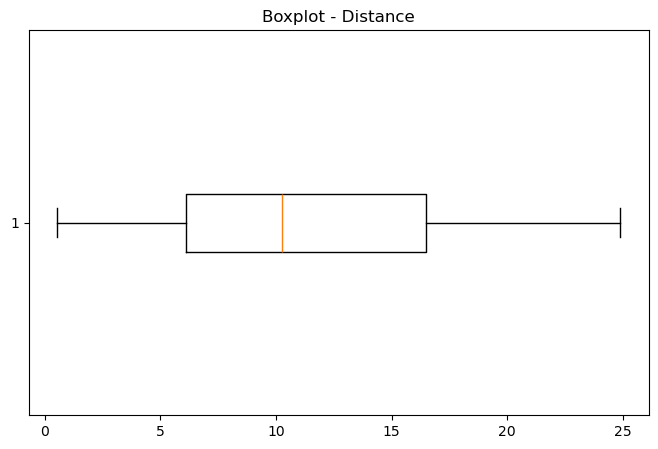

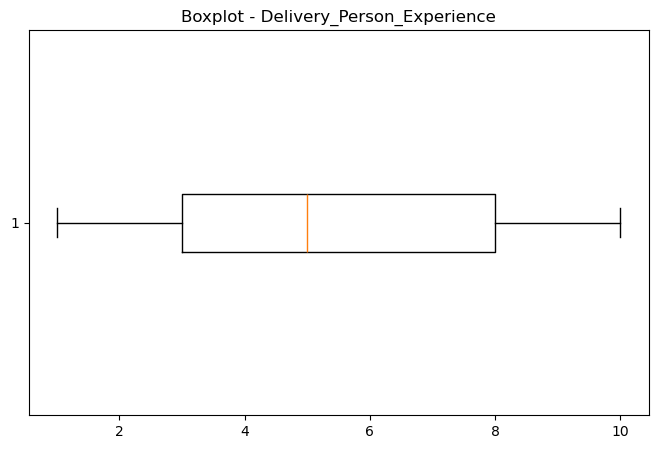

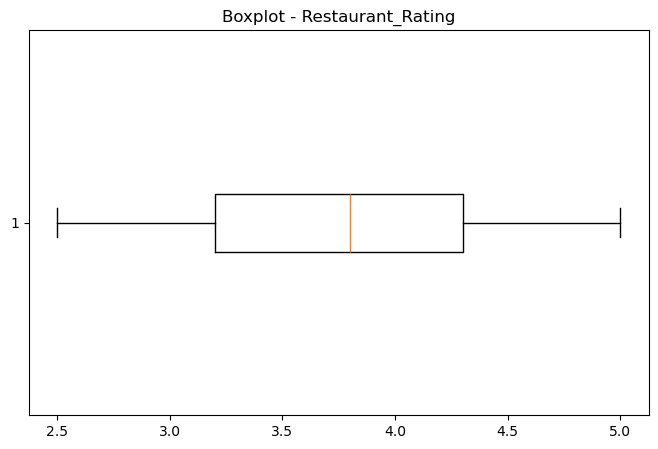

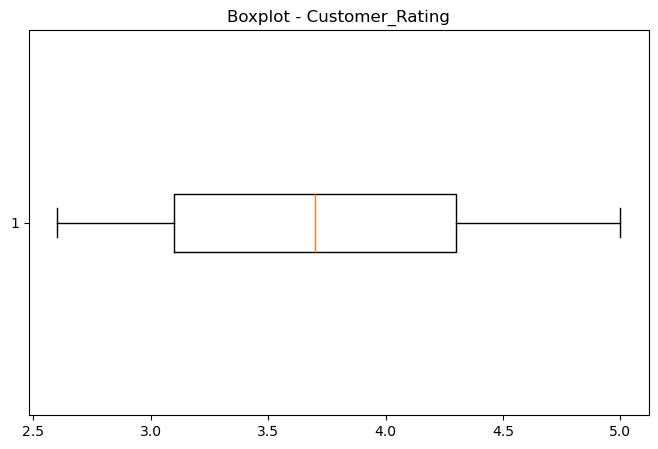

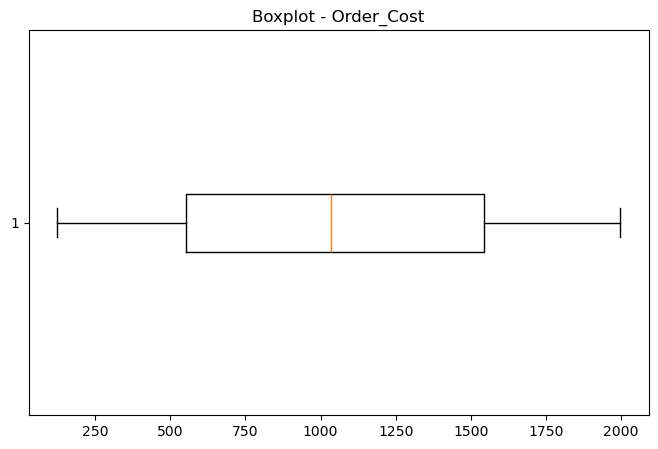

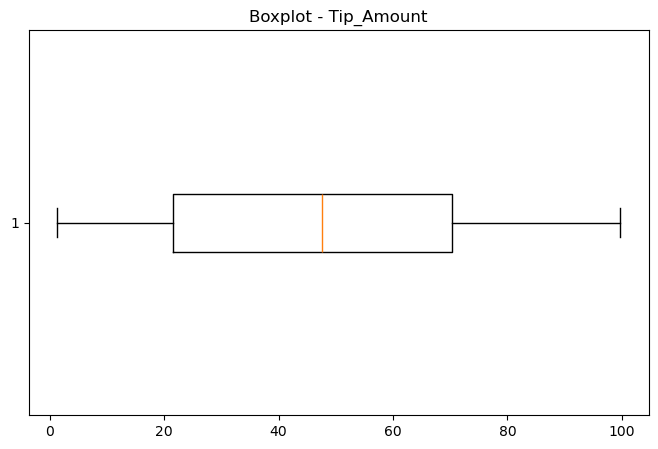

In [16]:


def haversine_np(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km


possible_pairs = []
for a in df.columns:
    for b in df.columns:
        if a!=b and 'lat' in a.lower() and 'lon' in b.lower():
            possible_pairs.append((a,b))
if possible_pairs:
    print('Found lat-lon column pairs (sample):', possible_pairs[:4])
    lat_cols = [c for c in df.columns if 'lat' in c.lower()]
    lon_cols = [c for c in df.columns if 'lon' in c.lower()]
    if len(lat_cols)>=2 and len(lon_cols)>=2:
        cust_lat, rest_lat = lat_cols[0], lat_cols[1]
        cust_lon, rest_lon = lon_cols[0], lon_cols[1]
        try:
            df['Haversine_km'] = haversine_np(df[cust_lat], df[cust_lon], df[rest_lat], df[rest_lon])
            print('Haversine distance computed using', cust_lat, cust_lon, rest_lat, rest_lon)
        except Exception as e:
            print('Haversine compute failed:', e)
else:
    print('No clear lat/lon columns detected; skipping Haversine.')


time_cols = [c for c in df.columns if 'time' in c.lower() or 'order_time' in c.lower() or 'timestamp' in c.lower()]
print('Potential time-related columns:', time_cols[:5])
if time_cols:
    tcol = time_cols[0]
    try:
        df['_parsed_time'] = pd.to_datetime(df[tcol], errors='coerce')
        df['hour'] = df['_parsed_time'].dt.hour
        df['dayofweek'] = df['_parsed_time'].dt.dayofweek
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if (x>=7 and x<=10) or (x>=16 and x<=19) else 0)
        print('Extracted hour, dayofweek, rush_hour from', tcol)
    except Exception as e:
        print('Time parsing failed:', e)
else:
    print('No time-like column detected; you can create hour/rush features if you have order timestamps.')


for col in numeric_cols[:6]:
    try:
        plt.figure()
        plt.boxplot(df[col].dropna(), vert=False)
        plt.title('Boxplot - ' + col)
        plt.show()
    except Exception as e:
        pass


In [17]:


y_reg = df[target_col].astype(float)


threshold = y_reg.median()
df['is_fast'] = (y_reg <= threshold).astype(int)
y_clf = df['is_fast']


features = []
if 'Haversine_km' in df.columns:
    features.append('Haversine_km')

features += [c for c in numeric_cols if c not in features]

for c in ['hour','dayofweek','rush_hour']:
    if c in df.columns and c not in features:
        features.append(c)

cat_for_model = categorical_cols[:6]
print('Using categorical columns for encoding:', cat_for_model)

X = df[features + cat_for_model].copy()
display('Feature sample', X.head())

numeric_features = [c for c in X.columns if c not in cat_for_model]
categorical_features = cat_for_model

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], remainder='drop')

X_trans = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
ohe_features = []
if categorical_features:
    try:
        ohe_features = list(ohe.get_feature_names_out(categorical_features))
    except:
        ohe_features = [f'cat_{i}' for i in range(len(categorical_features))]

feature_names = numeric_features + ohe_features
print('Final number of features after transform:', len(feature_names))


Using categorical columns for encoding: ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Weather_Conditions', 'Traffic_Conditions', 'Order_Priority']


'Feature sample'

,Distance,Delivery_Person_Experience,Restaurant_Rating,Customer_Rating,Order_Cost,Tip_Amount,hour,dayofweek,rush_hour,Order_ID,Customer_Location,Restaurant_Location,Weather_Conditions,Traffic_Conditions,Order_Priority
0,1.57,4,4.1,3.0,1321.10,81.54,NaN,NaN,0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",Rainy,Medium,Medium
1,21.32,8,4.5,4.2,152.21,29.02,NaN,NaN,0,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",Cloudy,Medium,Low
2,6.95,9,3.3,3.4,1644.38,64.17,NaN,NaN,0,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",Snowy,Medium,High
3,13.79,2,3.2,3.7,541.25,79.23,NaN,NaN,0,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",Cloudy,Low,Medium
4,6.72,6,3.5,2.8,619.81,2.34,NaN,NaN,0,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",Rainy,High,Low


Final number of features after transform: 619


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)


X_trans = preprocessor.fit_transform(X)


✅ Best Ridge alpha: {'alpha': 100}
✅ Best RF params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}

📊 Ridge Regression Metrics: {'MSE': 953.0702057131617, 'MAE': 25.965712933751508, 'R2': -0.030467363067273157}
📊 Random Forest Metrics: {'MSE': 1059.4971735547692, 'MAE': 27.374289909409963, 'R2': -0.14553707803011107}


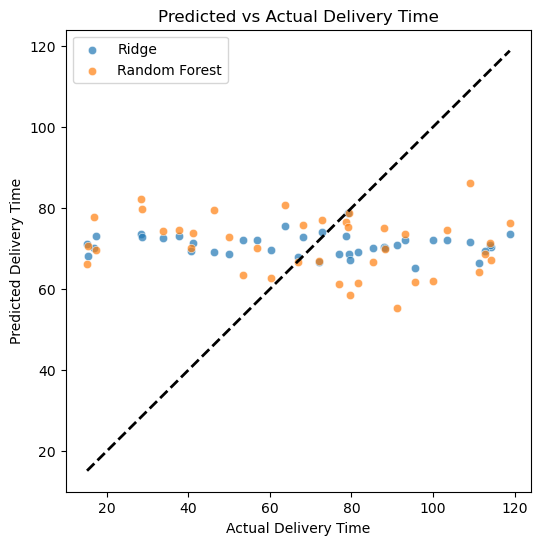

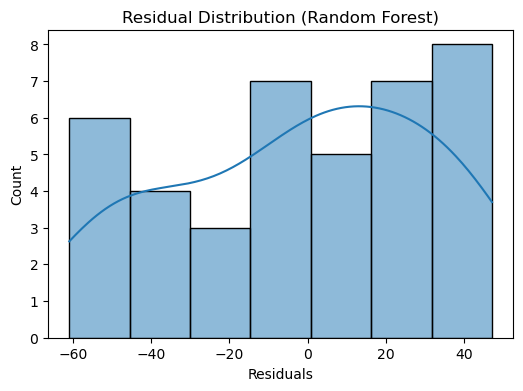

In [19]:



X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X_trans, y_reg, y_clf, test_size=0.2, random_state=42
)


y_train_reg = pd.to_numeric(y_train_reg, errors="coerce").ravel()
y_test_reg = pd.to_numeric(y_test_reg, errors="coerce").ravel()


from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
params_ridge = {'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train_reg)

best_ridge = grid_ridge.best_estimator_
print('✅ Best Ridge alpha:', grid_ridge.best_params_)


from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
params_rf = {
    'n_estimators':[50,100],
    'max_depth':[5,10,None],
    'min_samples_split':[2,5]
}
grid_rf = GridSearchCV(rf, params_rf, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train_reg)

best_rf = grid_rf.best_estimator_
print('✅ Best RF params:', grid_rf.best_params_)


best_ridge.fit(X_train, y_train_reg)
best_rf.fit(X_train, y_train_reg)


y_pred_ridge = best_ridge.predict(X_test)
y_pred_rf = best_rf.predict(X_test)


def reg_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

metrics_ridge = reg_metrics(y_test_reg, y_pred_ridge)
metrics_rf = reg_metrics(y_test_reg, y_pred_rf)

print('\n📊 Ridge Regression Metrics:', metrics_ridge)
print('📊 Random Forest Metrics:', metrics_rf)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_ridge, label="Ridge", alpha=0.7)
sns.scatterplot(x=y_test_reg, y=y_pred_rf, label="Random Forest", alpha=0.7)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'k--', lw=2)
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Predicted vs Actual Delivery Time")
plt.legend()
plt.show()


residuals = y_test_reg - y_pred_rf
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Random Forest)")
plt.xlabel("Residuals")
plt.show()


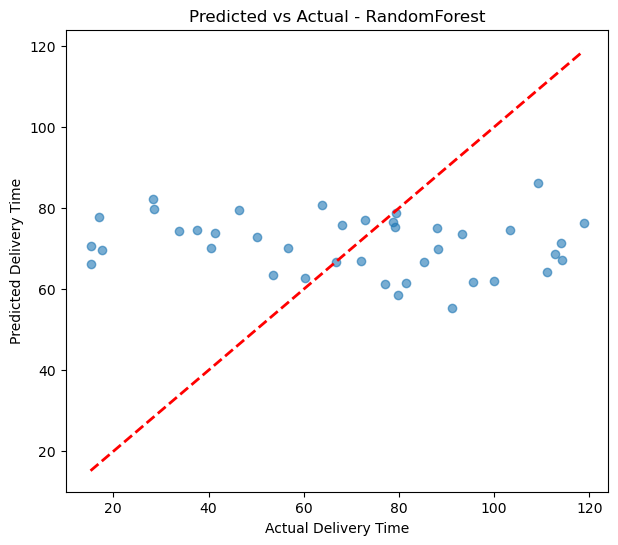

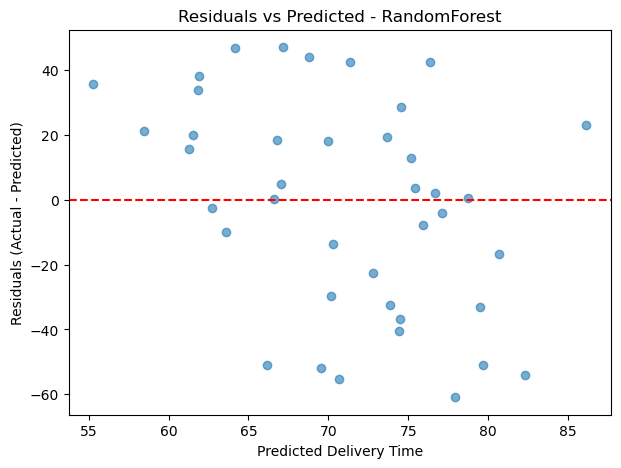

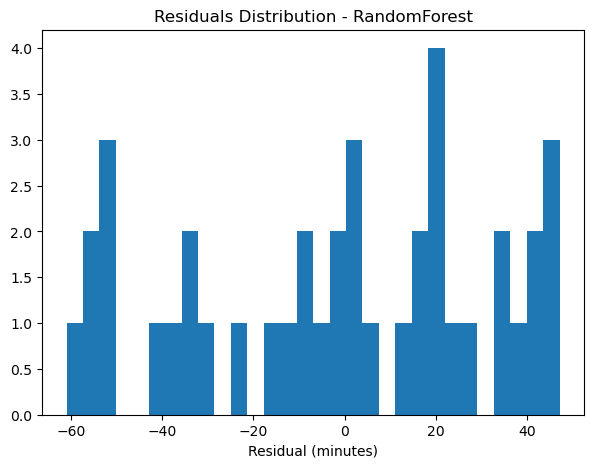

In [20]:


plt.figure(figsize=(7,6))
plt.scatter(y_test_reg, y_pred_rf, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', linewidth=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Predicted vs Actual - RandomForest');
plt.show()


residuals = y_test_reg - y_pred_rf
plt.figure(figsize=(7,5))
plt.scatter(y_pred_rf, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted - RandomForest')
plt.show()


plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30)
plt.title('Residuals Distribution - RandomForest')
plt.xlabel('Residual (minutes)')
plt.show()


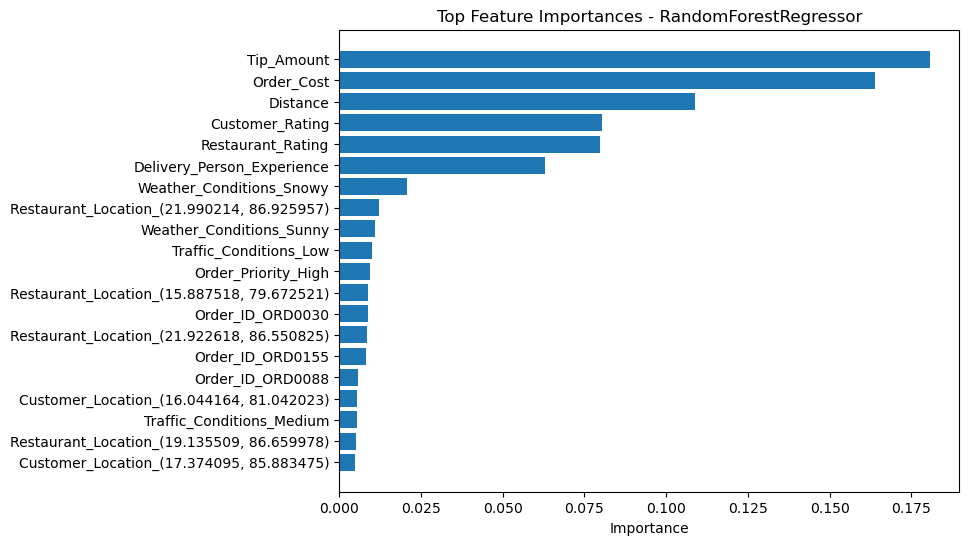

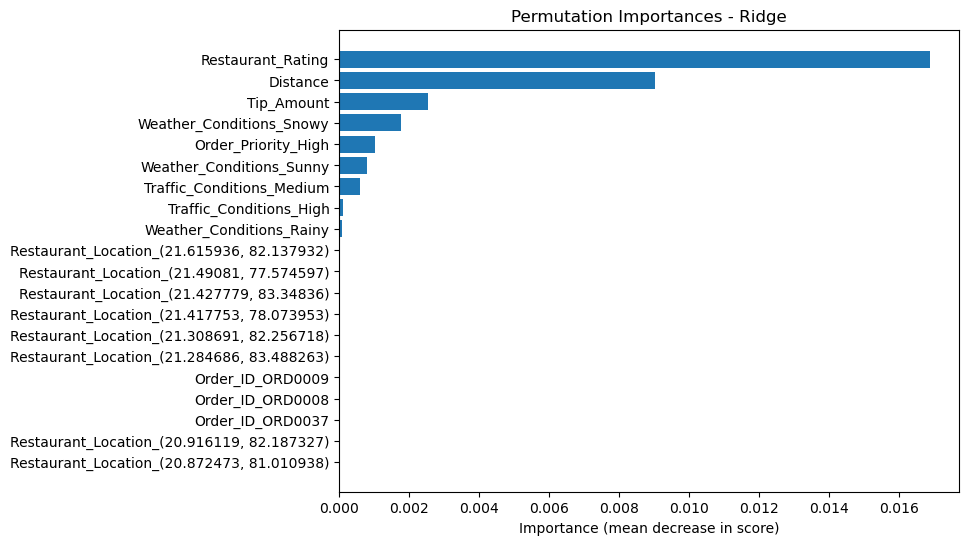

In [21]:


try:
    importances = best_rf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_n = min(20, len(importances))
    plt.figure(figsize=(8,6))
    plt.barh([feature_names[i] for i in sorted_idx[:top_n]][::-1], importances[sorted_idx[:top_n]][::-1])
    plt.title('Top Feature Importances - RandomForestRegressor')
    plt.xlabel('Importance')
    plt.show()
except Exception as e:
    print('Could not compute RF importances:', e)


try:
    r = permutation_importance(best_ridge, X_test, y_test_reg, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = r.importances_mean.argsort()[::-1]
    top_n = min(20, len(r.importances_mean))
    plt.figure(figsize=(8,6))
    plt.barh([feature_names[i] for i in sorted_idx[:top_n]][::-1], r.importances_mean[sorted_idx[:top_n]][::-1])
    plt.title('Permutation Importances - Ridge')
    plt.xlabel('Importance (mean decrease in score)')
    plt.show()
except Exception as e:
    print('Permutation importance failed:', e)


In [22]:


Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_trans, y_clf.values, test_size=0.2, random_state=42)


logreg = LogisticRegression(max_iter=1000)
params_log = {'C':[0.01,0.1,1,10], 'penalty':['l2'], 'solver':['lbfgs']}
grid_log = GridSearchCV(logreg, params_log, cv=5, scoring='accuracy', n_jobs=-1)
grid_log.fit(Xc_train, yc_train)
best_log = grid_log.best_estimator_
print('Best Logistic params:', grid_log.best_params_)

rfc = RandomForestClassifier(random_state=42)
params_rfc = {'n_estimators':[50,100], 'max_depth':[5,10,None]}
grid_rfc = GridSearchCV(rfc, params_rfc, cv=4, scoring='accuracy', n_jobs=-1)
grid_rfc.fit(Xc_train, yc_train)
best_rfc = grid_rfc.best_estimator_
print('Best RFC params:', grid_rfc.best_params_)

best_log.fit(Xc_train, yc_train)
best_rfc.fit(Xc_train, yc_train)

yhat_log = best_log.predict(Xc_test)
yhat_rfc = best_rfc.predict(Xc_test)

def clf_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    }

print('\nLogistic metrics:', clf_metrics(yc_test, yhat_log))
print('RandomForestClassifier metrics:', clf_metrics(yc_test, yhat_rfc))


Best Logistic params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best RFC params: {'max_depth': None, 'n_estimators': 100}

Logistic metrics: {'Accuracy': 0.525, 'Precision': 0.5, 'Recall': 0.631578947368421, 'F1': 0.5581395348837209}
RandomForestClassifier metrics: {'Accuracy': 0.325, 'Precision': 0.25, 'Recall': 0.21052631578947367, 'F1': 0.22857142857142856}


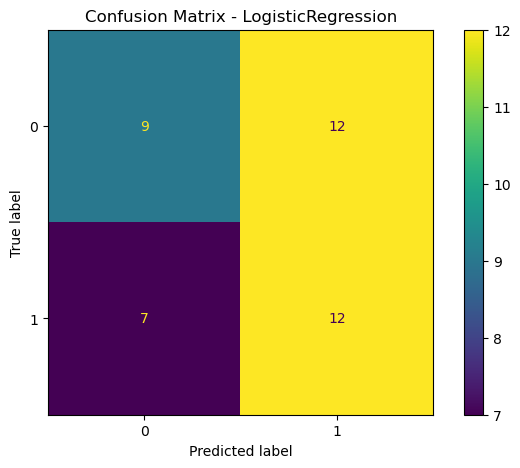

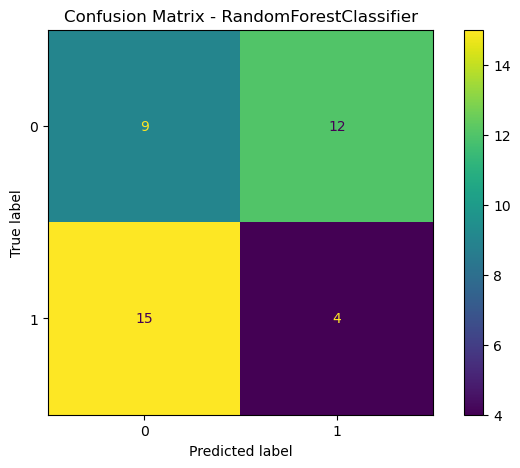

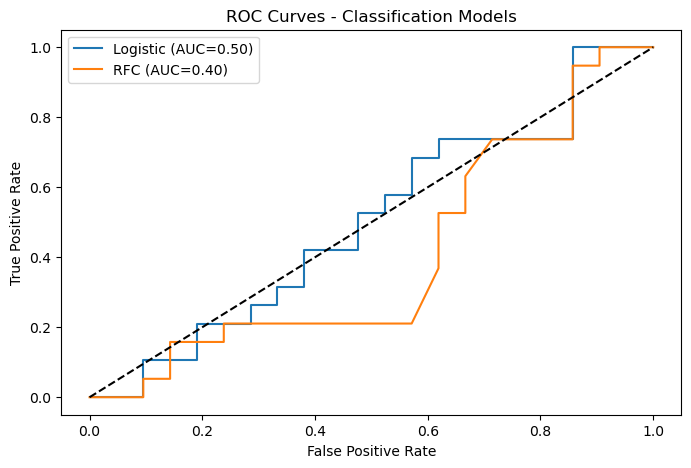

In [23]:


disp = ConfusionMatrixDisplay(confusion_matrix(yc_test, yhat_log))
disp.plot()
plt.title('Confusion Matrix - LogisticRegression')
plt.show()

disp2 = ConfusionMatrixDisplay(confusion_matrix(yc_test, yhat_rfc))
disp2.plot()
plt.title('Confusion Matrix - RandomForestClassifier')
plt.show()


yprob_log = best_log.predict_proba(Xc_test)[:,1] if hasattr(best_log, 'predict_proba') else best_log.decision_function(Xc_test)
yprob_rfc = best_rfc.predict_proba(Xc_test)[:,1]
fpr1, tpr1, _ = roc_curve(yc_test, yprob_log)
fpr2, tpr2, _ = roc_curve(yc_test, yprob_rfc)
plt.figure()
plt.plot(fpr1, tpr1, label=f'Logistic (AUC={auc(fpr1,tpr1):.2f})')
plt.plot(fpr2, tpr2, label=f'RFC (AUC={auc(fpr2,tpr2):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Classification Models')
plt.legend()
plt.show()


In [24]:


print('Actionable Insights:')
print('- Feature importances show which features affect delivery time the most. Focus on improving those drivers (e.g., distance, traffic conditions).')
print('- If time-of-day (rush hour) is a strong predictor, consider dynamic staffing during peak hours.')
print('- If weather shows high impact, plan alternate routing or buffer times for bad-weather days.')
print('- Use the regression model predictions to give customers realistic ETA windows and to prioritize deliveries.\n')




Actionable Insights:
- Feature importances show which features affect delivery time the most. Focus on improving those drivers (e.g., distance, traffic conditions).
- If time-of-day (rush hour) is a strong predictor, consider dynamic staffing during peak hours.
- If weather shows high impact, plan alternate routing or buffer times for bad-weather days.
- Use the regression model predictions to give customers realistic ETA windows and to prioritize deliveries.

